Attempt to debug weird vertex reconstruction feature, namely that reco vertex distribution was higher than gen for large displacements. Apparently the issue arises from low-displacement gen vertices, which are reconstructed as high-displacement reco vertices. The likely reason is that we are using dSA muon collection, which only uses muon chambers (at the very outer part of CMS) and has no vertex constraint. So for low-displacement gen vertices, the track has to be extrapolated inwards significantly, and the resolution suffers as a result.

In the process of debugging this, also found a "bug" in that some reconstructed muons weren't properly sorted by pT before trying the gen-matching procedure. The implication was that in some cases, when more than 2 muons were reconstructed (only 2 of them due to the signal of course), the gen matching procedure could select a muon that was very soft and not coming from the iDM, if the dR was compatible. So just sort muons by pT before gen-matching to mitigiate this.

In the course of figuring this out I accidentally introduced a code bug which was promptly fixed (not resetting some ROOT branch variables between events -- so was getting exactly duplicate momenta across events).

In [1]:
import uproot
import ROOT
import numpy as np
import pandas as pd
from collections import OrderedDict
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.style.use('default')
plt.rcParams['grid.linestyle'] = ':'

Welcome to JupyROOT 6.12/04


In [2]:
import sys
sys.version
sys.version_info

sys.version_info(major=3, minor=6, micro=3, releaselevel='final', serial=0)

In [3]:
sortedmudfs = uproot.open('../Firefighter/washAOD/TrigRecoEffStudies/Mchi-60_dMchi-20_ctau-100_sortedMu.root')['RECO_dsa/TrigRecoEffi'].pandas.df()

Count number of events where leading mu pT is greater than subleading mu pT 
(Will happen if muons are not sorted by pT originally)

In [4]:
(sortedmudfs.query('subentry==0').reset_index(level='subentry')['recoLeadingMuPt'] > \
sortedmudfs.query('subentry==0').reset_index(level='subentry')['recoSubleadingMuPt']).value_counts()

True     16645
False     1646
dtype: int64

Plot subleading gen vs reco muon pT

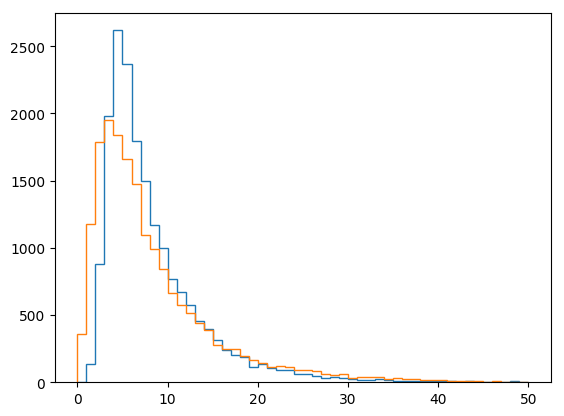

In [5]:
plt.hist(sortedmudfs.query('subentry==0')['recoSubleadingMuPt'].dropna(), bins=50, range=(0,50),histtype='step');
plt.hist(sortedmudfs.query('subentry==1')['genPt'].dropna(), bins=50, range=(0,50),histtype='step');

Plot genVxy vs recoVxy for events with 2 muons reco'd (only have vertex if so)

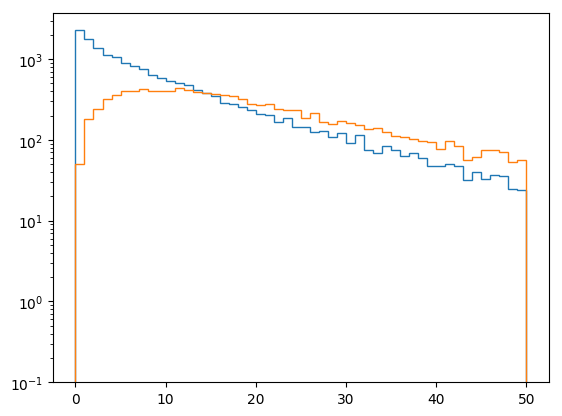

In [6]:
plt.hist(sortedmudfs.query('subentry==0')['genVxy'], bins=50, range=(0,50),histtype='step',log=True);
plt.hist(sortedmudfs.query('nMatched==2')['recoVxy'].dropna(), bins=50, range=(0,50),histtype='step');

Plot distribution of total number of reco'd muons

1    8748
0    8137
2    1028
3     298
4      66
5       8
6       6
Name: recoAllMuPt, dtype: int64

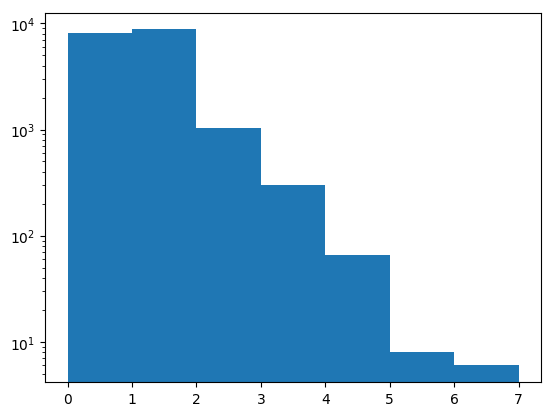

In [7]:
# plt.hist(sortedmudfs['recoAllMuPt'].reset_index().groupby('entry').size(), log=True, bins=[1,2,3,4,5,6,7])
plt.hist(sortedmudfs.groupby('entry').count()['recoAllMuPt'], bins=[0,1,2,3,4,5,6,7], log=True);
sortedmudfs.groupby('entry').count()['recoAllMuPt'].value_counts()

Group by entries and count number of reco'd muons in each group (a group = an event)

In [8]:
sortedmudfs.groupby('entry').count()['recoAllMuPt']#.loc[lambda x : x == 3]
# sortedmudfs.groupby('entry').groups
# df['count'] = df.groupby(['col1', 'col2'])['col3'].transform('count')

entry
0        1
1        0
2        2
3        1
4        1
5        0
6        0
7        1
8        1
9        1
10       0
11       0
12       0
13       1
14       1
15       1
16       1
17       0
18       1
19       1
20       1
21       0
22       1
23       0
24       0
25       0
26       1
27       1
28       3
29       1
        ..
18261    1
18262    1
18263    0
18264    1
18265    0
18266    0
18267    1
18268    2
18269    0
18270    1
18271    0
18272    1
18273    0
18274    0
18275    1
18276    0
18277    0
18278    1
18279    0
18280    0
18281    0
18282    1
18283    0
18284    1
18285    0
18286    1
18287    0
18288    0
18289    2
18290    1
Name: recoAllMuPt, Length: 18291, dtype: int64

Count how many events with duplicate pTs we have

In [9]:
sortedmudfs.groupby('entry').count()['recoAllMuPt']
sortedmudfs['mucount']=sortedmudfs.groupby('entry')['recoAllMuPt'].transform(lambda x : x.count())

Filter by events where number of duplicates == 2

In [10]:
sortedmudfs[['recoAllMuPt','recoAllMuEta','mucount']].query('mucount==2') \
.groupby('entry')['recoAllMuPt'].transform(lambda x : 2*x == x.sum()).value_counts()

False    1250
True      806
Name: recoAllMuPt, dtype: int64

In [13]:
bugfixdf = uproot.open('../Firefighter/washAOD/TrigRecoEffStudies/Mchi-60_dMchi-20_ctau-100_sortedMu_bugfix.root')['RECO_dsa/TrigRecoEffi'].pandas.df()

Count number of events where the muon pT is duplicated (if only False events then have zero duplicated -- bug fixed!)

In [14]:
bugfixdf.groupby('entry').count()['recoAllMuPt'] # Gives series with number of reco jets for each entry, no subentries
bugfixdf['mucount']=bugfixdf.groupby('entry')['recoAllMuPt'].transform(lambda x : x.count()) # Same, except each subentry is filled with count instead

bugfixdf[['recoAllMuPt','recoAllMuEta','mucount']].query('mucount==2') \
.groupby('entry')['recoAllMuPt'].transform(lambda x : 2*x == x.sum()).value_counts()

False    26060
Name: recoAllMuPt, dtype: int64

Plot genVxy and recoVxy for events w/ 2 reco'd muons and also evetns w/ 2 reco'd muons && trigger fired

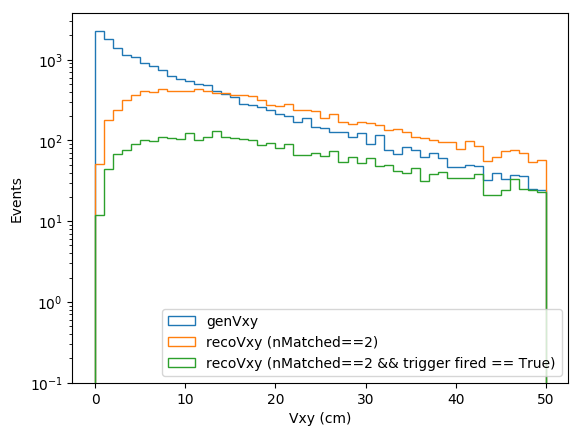

In [15]:
plt.hist(bugfixdf.query('subentry==0')['genVxy'], bins=50, range=(0,50),histtype='step',log=True, label='genVxy');
plt.hist(bugfixdf.query('subentry==0&nMatched==2')['recoVxy'].dropna(), bins=50, range=(0,50),histtype='step', label='recoVxy (nMatched==2)');
plt.hist(bugfixdf.query('subentry==0&nMatched==2&fired==True')['recoVxy'].dropna(), bins=50, range=(0,50),histtype='step', label='recoVxy (nMatched==2 && trigger fired == True)');
plt.legend(loc='lower right');
plt.xlabel('Vxy (cm)');
plt.ylabel('Events');

Plot residual between reco and gen vxy

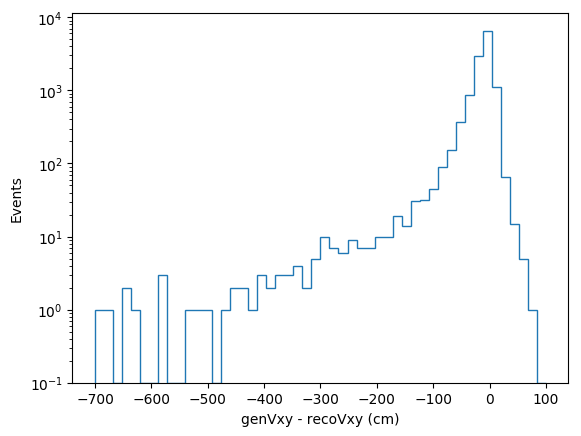

In [17]:
plt.hist(bugfixdf.query('subentry==0').dropna()['genVxy'] - \
         bugfixdf.query('subentry==0&nMatched==2').dropna()['recoVxy'], bins=50,range=(-700,100),log=True,histtype='step')
plt.xlabel('genVxy - recoVxy (cm)')
plt.ylabel('Events');

Same but for vz

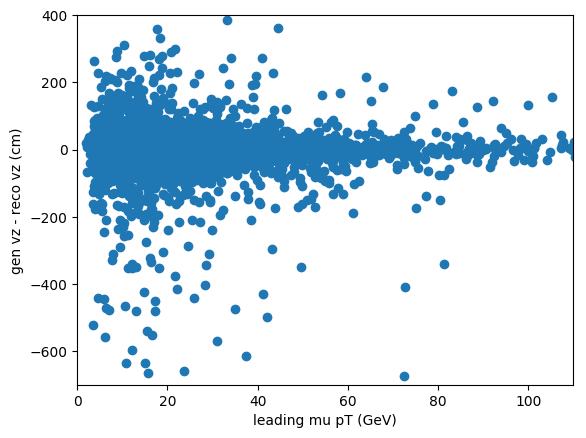

In [19]:
plt.scatter(bugfixdf.query('subentry==0').dropna()['recoLeadSubleadMuPt'], bugfixdf.query('subentry==0').dropna()['genVz'] - \
         bugfixdf.query('subentry==0&nMatched==2').dropna()['recoVz'])# \
         #,bins=50,range=(-500,100),histtype='step',log=True)
plt.xlim(0,110)
plt.ylim(-700,400)
plt.xlabel('leading mu pT (GeV)')
plt.ylabel('gen vz - reco vz (cm)');

Scatter plot of residual vs leading mu pT

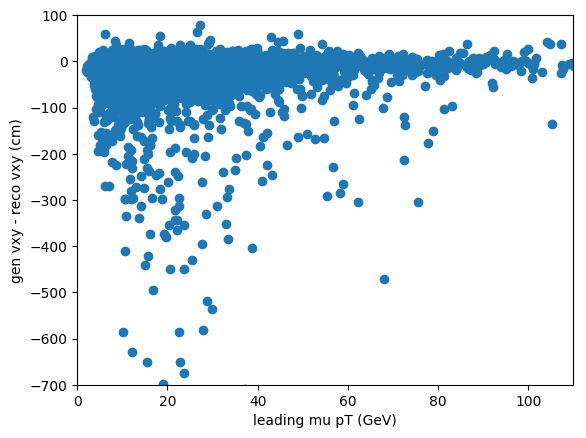

In [20]:
plt.scatter(bugfixdf.query('subentry==0').dropna()['recoLeadSubleadMuPt'], bugfixdf.query('subentry==0').dropna()['genVxy'] - \
         bugfixdf.query('subentry==0&nMatched==2').dropna()['recoVxy'])# \
         #,bins=50,range=(-500,100),histtype='step',log=True)
plt.xlim(0,110)
plt.ylim(-700,100)
plt.xlabel('leading mu pT (GeV)')
plt.ylabel('gen vxy - reco vxy (cm)');

Same but residual vs genVxy

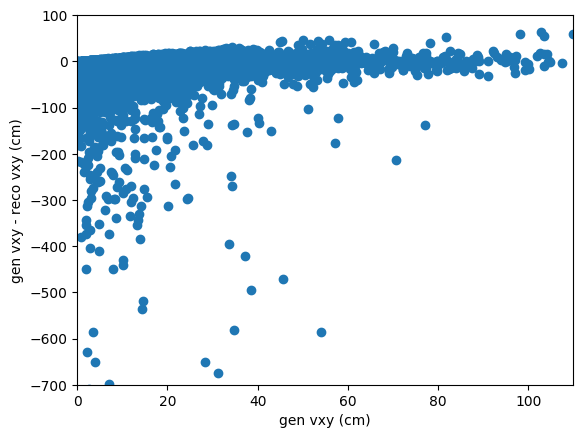

In [21]:
plt.scatter(bugfixdf.query('subentry==0').dropna()['genVxy'], bugfixdf.query('subentry==0').dropna()['genVxy'] - \
         bugfixdf.query('subentry==0&nMatched==2').dropna()['recoVxy'])# \
         #,bins=50,range=(-500,100),histtype='step',log=True)
plt.xlim(0,110)
plt.ylim(-700,100)
plt.xlabel('gen vxy (cm)')
plt.ylabel('gen vxy - reco vxy (cm)');

Leading mu pT, gen vs reco

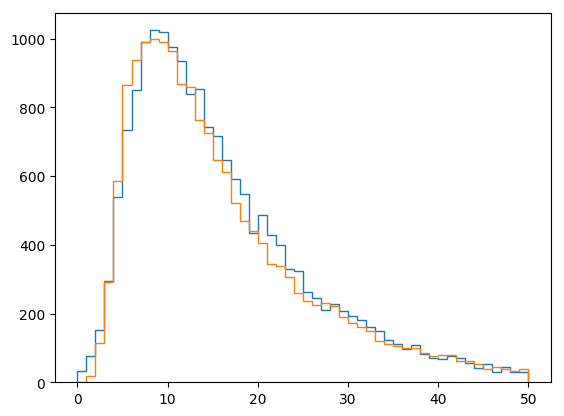

In [22]:
plt.hist(bugfixdf.query('subentry==0')['genPt'].dropna(), bins=50, range=(0,50),histtype='step')
plt.hist(bugfixdf.query('subentry==0')['recoLeadSubleadMuPt'].dropna(), bins=50, range=(0,50),histtype='step');

Plot distribution of total number of reco'd muons -- looks a lot better

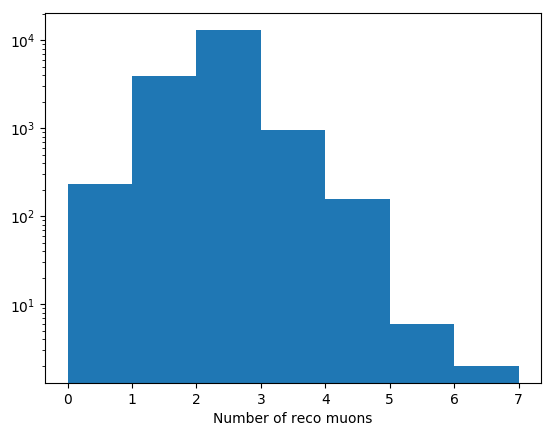

In [24]:
plt.hist(bugfixdf.groupby('entry').count()['recoAllMuPt'], bins=[0,1,2,3,4,5,6,7], log=True)
bugfixdf.groupby('entry').count()['recoAllMuPt'].value_counts()
plt.xlabel('Number of reco muons');

Vertex residual as a function of subleading muon pT

In [25]:
subleadingpt = bugfixdf.query('subentry==1')['recoLeadSubleadMuPt'].reset_index(level=1)[['recoLeadSubleadMuPt']].dropna()
diffvxy = (bugfixdf.query('subentry==1')['genVxy'].reset_index(level=1)['genVxy'] - bugfixdf.query('subentry==0&nMatched==2')['recoVxy'].reset_index(level=1)['recoVxy']).dropna().to_frame(name='genVxy - recoVxy')
ptvtxcomp = subleadingpt.join(diffvxy).dropna()
ptvtxcomp

,recoLeadSubleadMuPt,genVxy - recoVxy
entry,,
0,3.797682,-13.471857
1,7.290617,-62.559429
3,1.405068,-19.486246
4,5.543178,-4.869507
6,23.234234,5.458132
7,14.880137,-1.584113
8,3.438460,-13.301474
9,7.969414,-8.701872
10,4.797485,-5.208033


Scatter plot of residual and subleading mu pT

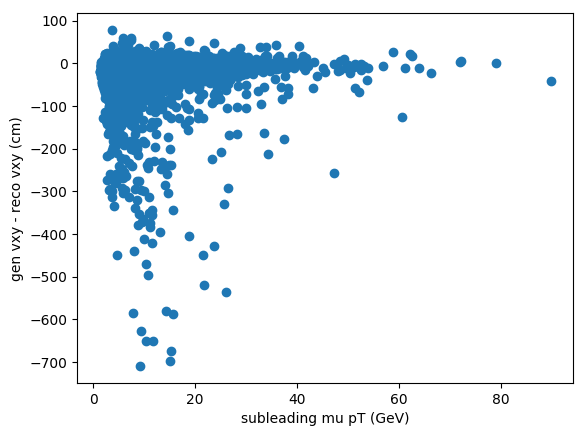

In [26]:
plt.scatter(ptvtxcomp['recoLeadSubleadMuPt'], ptvtxcomp['genVxy - recoVxy'])
# plt.xlim(0,110)
# plt.ylim(-700,100)
plt.xlabel('subleading mu pT (GeV)')
plt.ylabel('gen vxy - reco vxy (cm)');

Comparison between gen and reco MET

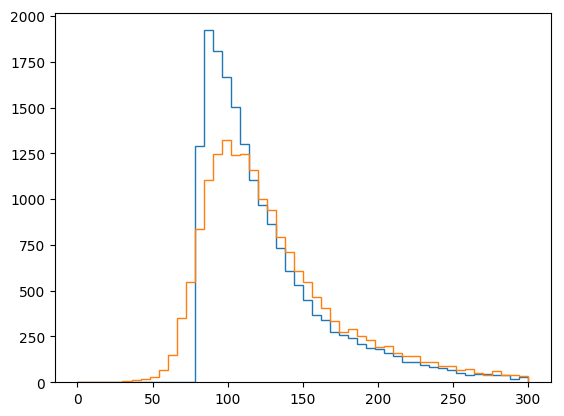

In [27]:
plt.hist(bugfixdf['genLeadMetPt'].dropna(),histtype='step',bins=50,range=(0,300))
plt.hist(bugfixdf['recoPFMetPt'].dropna(),histtype='step',bins=50,range=(0,300));

Comparison between gen and reco jet

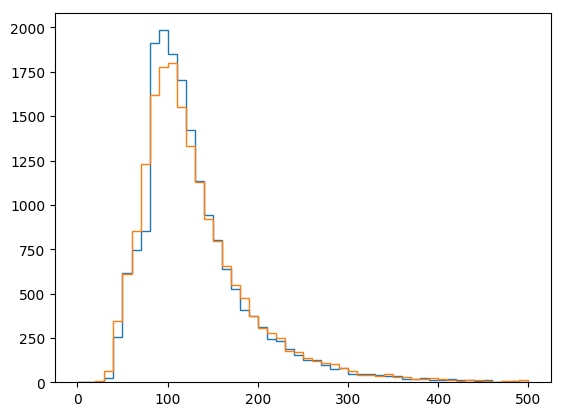

In [29]:
plt.hist(bugfixdf['genJetPt'].dropna(),histtype='step',bins=50,range=(0,500))
plt.hist(bugfixdf['recoJetPt'].dropna(),histtype='step',bins=50,range=(0,500));

Number of reco jets per event

In [28]:
# bugfixdf.groupby('entry').count()['recoJetPt'] # Gives series with number of reco jets for each entry, no subentries
bugfixdf['jetcount']=bugfixdf.groupby('entry')['recoJetPt'].transform(lambda x : x.count()) # Same, except each subentry is filled with count instead